In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
files = {
    2019: 'influd19_limpo-27.04.2020-final.csv',
#     2020: 'INFLUD-16-06-2020-Revisado.csv'
#     2020: 'INFLUD-30-06-2020.csv'
    2020: 'INFLUD-07-07-2020.csv'
}
encodings = {
    2019: 'ISO-8859-1',
    2020: 'ISO-8859-1'
}
samples = {k: pd.read_csv(v, sep=';', nrows=20) for k,v in files.items()}
date_cols = {k: [c for c in v.columns if c[:3]=='DT_'] for k,v in samples.items()}

In [2]:
datasets = {}
for k in files.keys():
    try:
        datasets[k] = pd.read_csv(files[k],
                                  encoding=encodings[k],
                                  sep=';', 
                                  parse_dates=date_cols[k], 
                                  dayfirst=True, 
                                  na_values='00000000')
    except Exception as err:
        print("{0}: {1}".format(k,err))

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (97,105,107,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,103,105,117,119,126,128,132) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
filters = {}
for ano in datasets.keys():
    f = []
    f.append('EVOLUCAO==2')
    f.append('CLASSI_FIN in [4, 5]')
    f.append('not CLASSI_FIN.isna()')
    filters[ano] = f

# Compara Município em 2019 e 2020

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


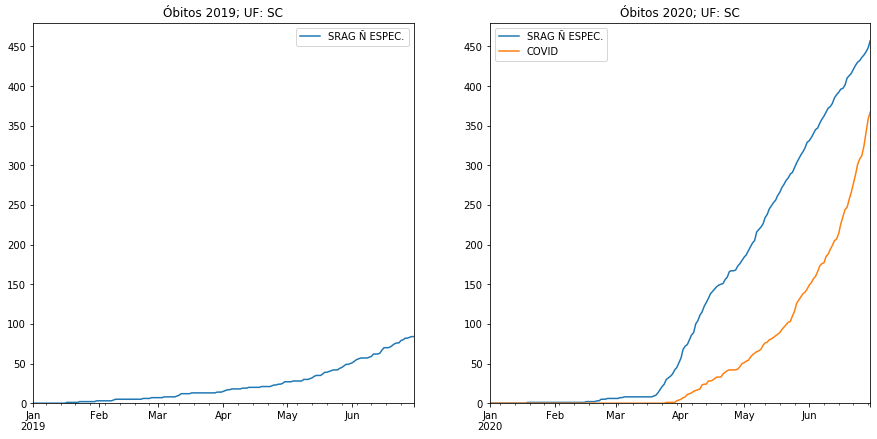

In [4]:
ref = '06-30'
uf = 'SC'
municipio_notif = ''
municipio_resid = ''

ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*7), constrained_layout=False)
consultas = {}
i = 0
for ano,dataset in datasets.items():
    f = []
    title = f'Óbitos {ano}'
    if uf:
        f.append(f'SG_UF=="{uf}"')
        title += '; UF: ' + uf
    if municipio_notif:
        f.append(f'ID_MUNICIP=="{municipio_notif}"')
        title += '; MUNIC_NOTIF: ' + municipio_notif
    if municipio_resid:
        f.append(f'ID_MN_RESI=="{municipio_resid}"')
        title += '; MUNIC_RESID: ' + municipio_resid
    f.append(f'DT_EVOLUCA<="{ano}-{ref}"')
    f = f + filters[ano]
    consultas[ano] = dataset.query(' and '.join(f))
    consultas[ano].loc[:,'CLASSI_FIN'] = consultas[ano].loc[:,'CLASSI_FIN'].apply(lambda x: 'SRAG Ñ ESPEC.' if x==4 else 'COVID')
    consultas[ano] = consultas[ano].groupby(['DT_EVOLUCA','CLASSI_FIN']).size()

    t_index = pd.date_range(start=f'{ano}-01-01', end=f'{ano}-{ref}', freq='1D')

    try:
        plot_data = consultas[ano].reset_index().pivot('DT_EVOLUCA','CLASSI_FIN',0).reindex(t_index).fillna(0)
        plot_data.columns.name = None
        plot_data = plot_data.cumsum()
        plot_data = plot_data.resample(rule='1D').pad()
        plot_data = plot_data.astype(int)
        y = list(plot_data.columns)
        y.reverse()
        plot_data.plot(y=y, ax=axes.flat[i], title = title)
        i += 1
    except Exception as err:
        print("{0}: {1}".format(ano,err))

max_y = 0
for ax in axes.flat:
    if ax.get_ylim()[1] > max_y:
        max_y = ax.get_ylim()[1]
from matplotlib.ticker import MaxNLocator
for ax in axes.flat:
    ax.set_ylim(0,max_y)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 737520.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 737549.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 737564.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 737576.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/usr/local/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to

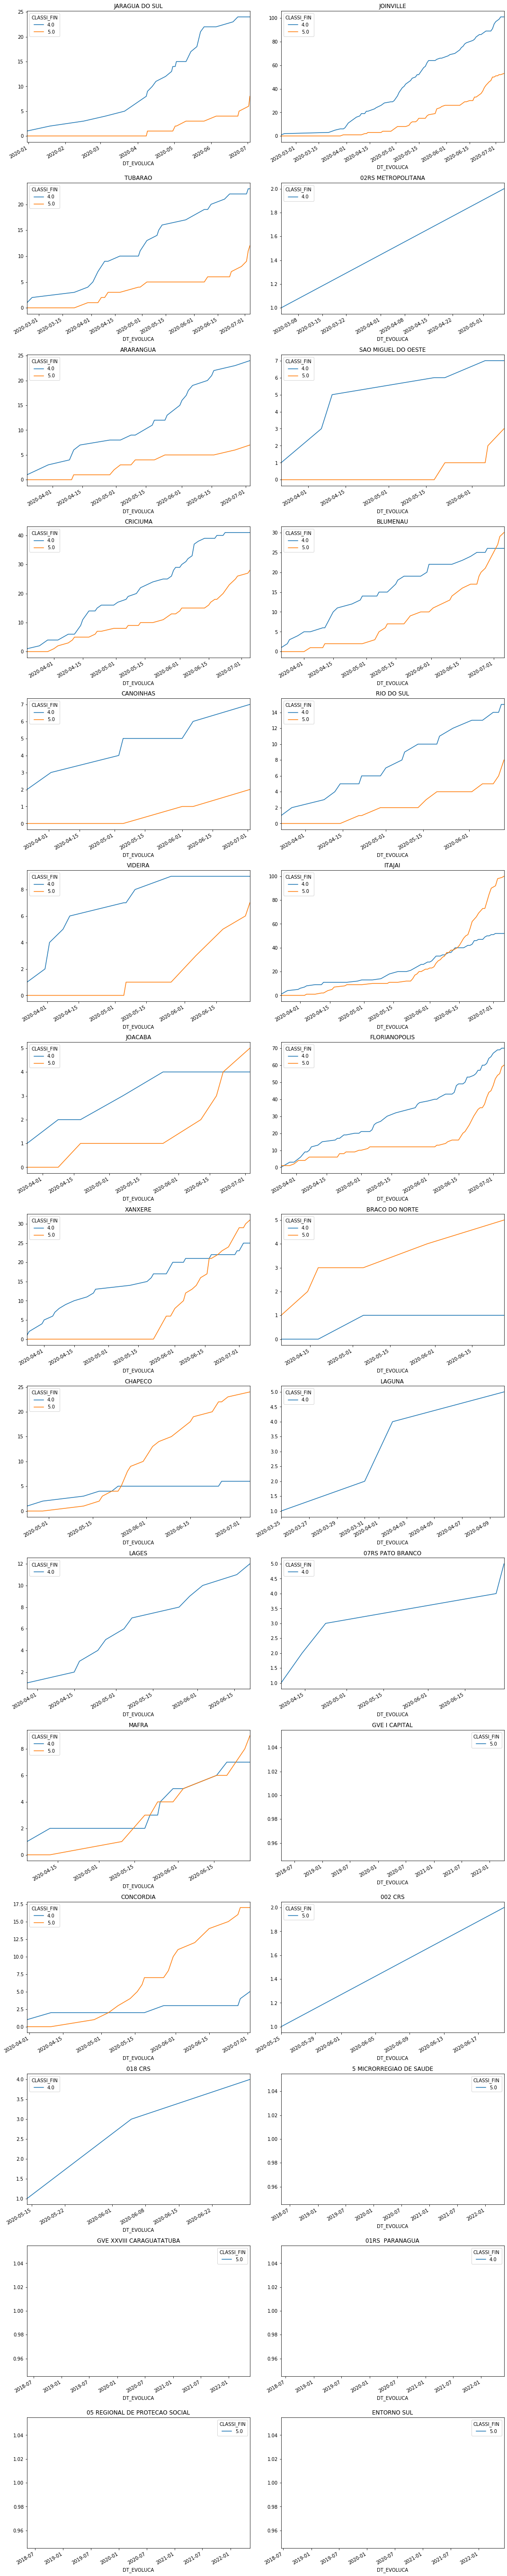

In [5]:
ano = 2020
dataset = datasets[2020]
dataset = dataset.query(f'SG_UF=="{uf}"')
regionais = dataset.query(' and '.join(filters[ano])).ID_REGIONA.drop_duplicates()

ncols = 2
nrows = len(regionais)//ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5), constrained_layout=False)

i = 0
for r in (regionais):
    consultas[ano] = dataset.query(' and '.join(filters[ano]))
    consultas[ano] = consultas[ano].query(f'ID_REGIONA=="{r}"')
    consultas[ano] = consultas[ano].query('CLASSI_FIN in [4.0, 5.0]')
    consultas[ano] = consultas[ano].groupby(['DT_EVOLUCA','CLASSI_FIN']).size()
    try:
        consultas[ano].reset_index().pivot('DT_EVOLUCA','CLASSI_FIN',0).fillna(0).cumsum().plot(title=r, ax=axes.flat[i])
        i +=1
    except:
        pass

while(i<len(axes.flat)):
    axes.flat[i].remove()
    i += 1
plt.tight_layout()

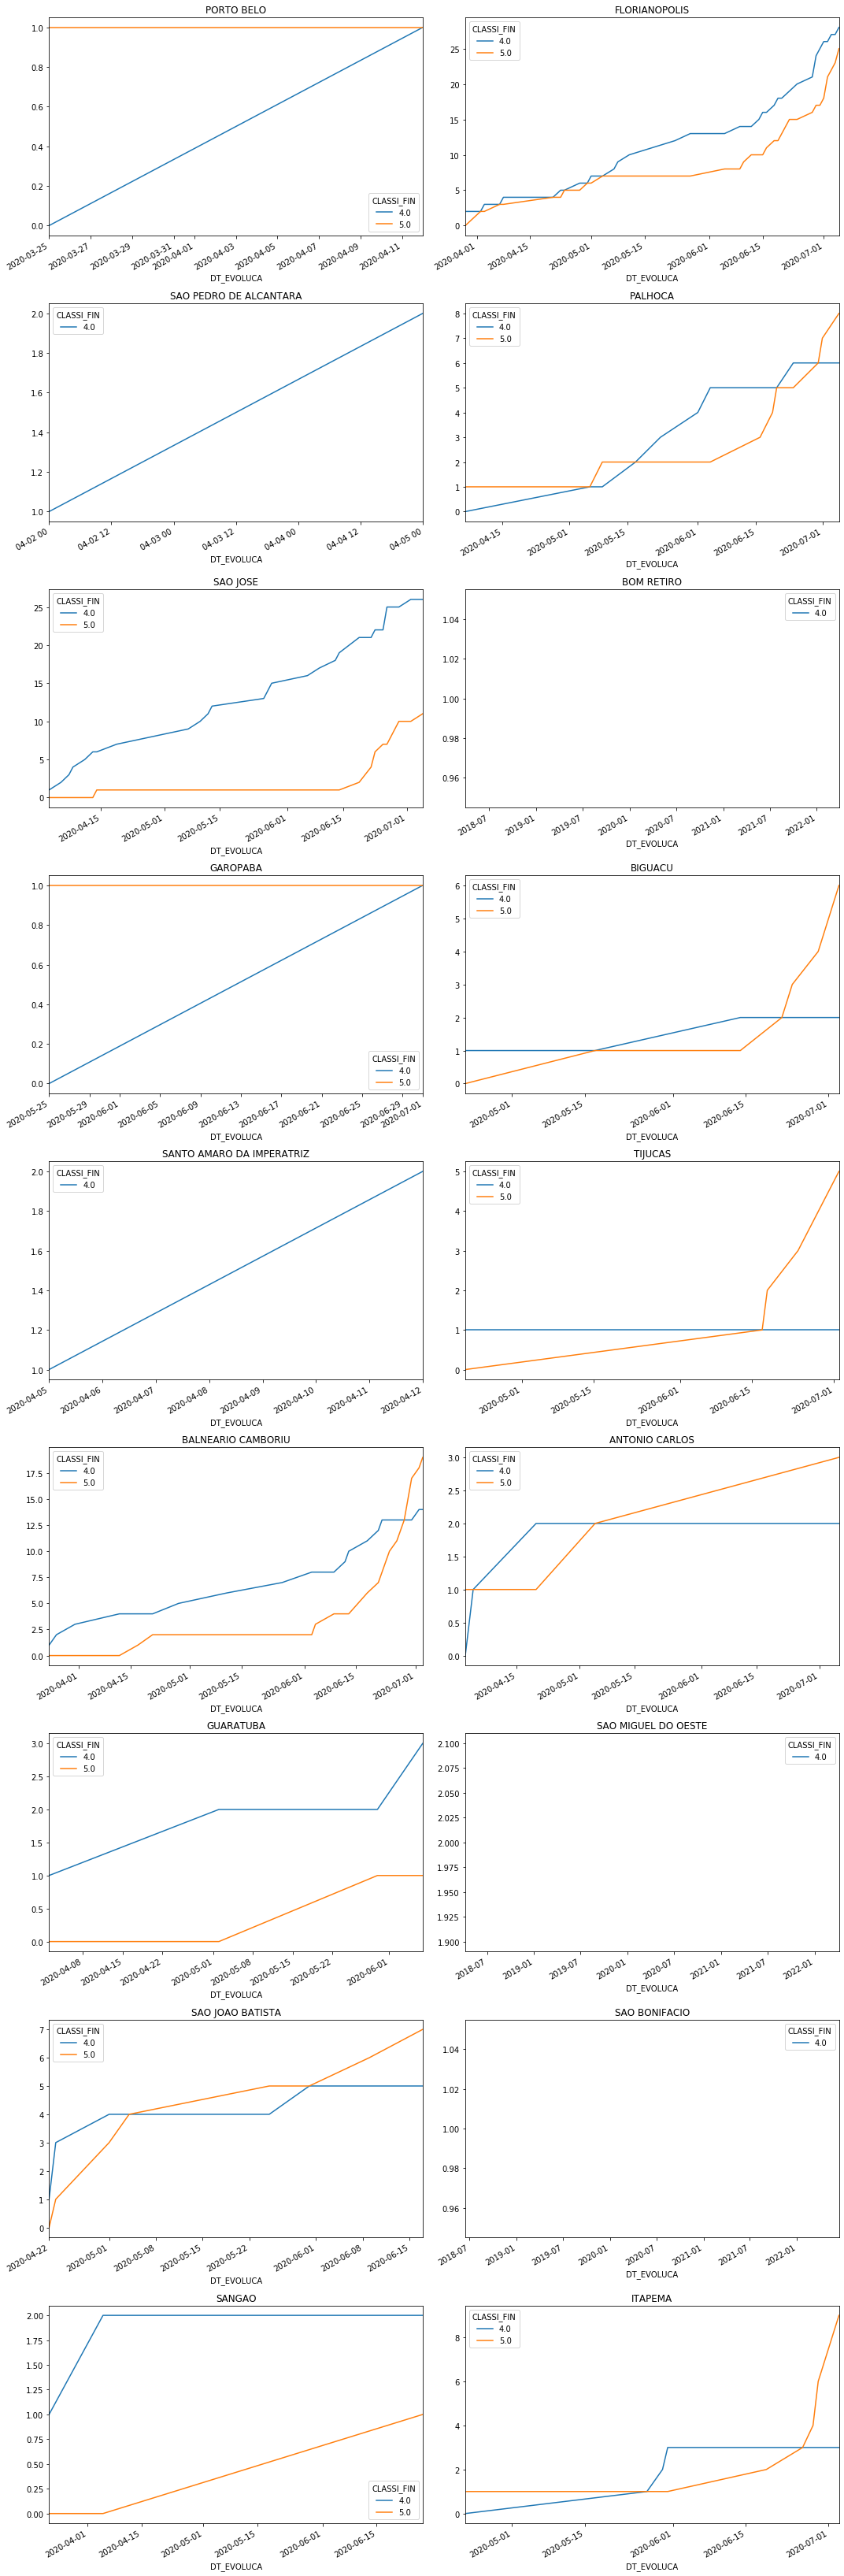

In [10]:
ano = 2020
dataset = datasets[2020]
local_filters = filters[ano] + ['ID_REGIONA=="FLORIANOPOLIS"']
municipios = dataset.query(' and '.join(local_filters)).ID_MN_RESI.drop_duplicates()

ncols = 2
nrows = len(regionais)//ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5), constrained_layout=False)


i = 0
for m in municipios:
    consultas[ano] = dataset.query(' and '.join(filters[ano]))
    consultas[ano] = consultas[ano].query(f'ID_MN_RESI=="{m}"')
    consultas[ano] = consultas[ano].groupby(['DT_EVOLUCA','CLASSI_FIN']).size()
    try:
        consultas[ano].reset_index().pivot('DT_EVOLUCA','CLASSI_FIN',0).fillna(0).cumsum().plot(title=m, 
                                                                                                ax=axes.flat[i])
        i += 1
    except:
        pass

while(i<len(axes.flat)):
    axes.flat[i].remove()
    i += 1
plt.tight_layout()